In [1]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import sklearn.neural_network._multilayer_perceptron as sk_mlp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy import optimize as opt
from IPython.display import clear_output
import sklearn.metrics as metrics

class_to_code = {
    0: 4,
    1: 33,
    2: 34,
    3: 35,
    4: 36,
    5: 48,
    6: 56,
    7: 57,
    8: 58,
    9: 59,
    10: 60,
    11: 61,
    12: 62,
    13: 63,
    14: 64,
    15: 65,
    16: 66,
    17: 67,
    18: 68,
    19: 69,
    20: 70,
    21: 71,
    22: 72,
}

code_to_class = {
    4: 0,
    33: 1,
    34: 2,
    35: 3,
    36: 4,
    48: 5,
    56: 6,
    57: 7,
    58: 8,
    59: 9,
    60: 10,
    61: 11,
    62: 12,
    63: 13,
    64: 14,
    65: 15,
    66: 16,
    67: 17,
    68: 18,
    69: 19,
    70: 20,
    71: 21,
    72: 22,
}


def categorize_time(time_str):
    hour, minute = map(int, time_str.split(':'))
    total_minutes = hour * 60 + minute
    category = int(total_minutes // ((24 * 60) / 48)) + 1
    return category

def categorize_values(value, max_value):
    interval = max_value / 40
    category = int(value // interval) + 1
    return category

class Data:
    def __init__(self, data):
        self.date = data.get("date", "")
        self.time = data.get("time", "")
        self.code = data.get("value1", 0)
        self.insuline = data.get("value2", 0)


def process_line_content(line):
    components = line.strip().split("\t")

    try:
        date, time, value1, value2 = components
    except Exception as e:
        return None

    try:
        value1 = int(value1.lstrip("0") if value1.lstrip("0") else 0)
    except Exception as e:
        pass

    try:
        value2 = int(value2.lstrip("0") if value2.lstrip("0") else 0)
    except Exception as e:
        return None

    value1 = code_to_class[value1]
    data = {
        "date": date,
        "time": time,
        "code": value1,
        "insuline": value2,
    }

    return data


def read_data_from_files(tar_file_path):
    aLL_patients_data = []
    files = os.listdir(tar_file_path)

    data_files = [file for file in files if file.startswith("data-")]

    for data_file in data_files:
        file_path = os.path.join(tar_file_path, data_file)
        with open(file_path, "r") as file_content:
            for line in file_content:
                patient_data = process_line_content(line)
                if patient_data:
                    aLL_patients_data.append(patient_data)


    return aLL_patients_data


def split_data(files_path, test_size=0.2):
    patients_data = read_data_from_files(files_path)
    df = pd.DataFrame(patients_data)

    X = df.drop(["code"], axis=1).drop(["date"], axis=1)
    X["time"] = X["time"].apply(categorize_time)
    max_value = X["insuline"].max()
    X["insuline"] = X["insuline"].apply(categorize_values, args=(max_value,) )
    y = df["code"]

    X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=test_size, random_state=42)
    return  X_train.values, X_test.values, y_train.values, y_test.values

## Split_data

- Read data from files from directory and combine them into one dataframe.
- Remove not used `date` column and extract `code` column as target values
- Convert `code` and `time` columns to categorical values
- Convert `insuline` column to categorical values
- Split data into train and test sets.

# Neural Network with Adam Optimization

This Python code defines a simple neural network with a perceptron architecture. The implementation includes support for multiple activation functions, regularization, and optimization using the Adam optimizer. The neural network is designed for classification tasks, and the code provides methods for training and prediction.

## Perceptron Class

The `Perceptron` class is the main implementation of the neural network. Here are the key attributes and methods:

### Initialization

- `__init__`: Initializes the perceptron with specified layer sizes, activation function, regularization strength, optimizer, and optimizer parameters (if using Adam).

### Activation Functions

- `sigmoid`, `sigmoid_derivative`: Sigmoid activation function and its derivative.
- `tanh`, `tanh_derivative`: Hyperbolic tangent activation function and its derivative.
- `relu`, `relu_derivative`: Rectified Linear Unit (ReLU) activation function and its derivative.
- `softmax`: Softmax activation function for the output layer.

### Loss and Gradient Functions

- `cross_entropy_loss`: Computes the cross-entropy loss between predicted and true labels.
- `cross_entropy_gradient`: Computes the gradient of the cross-entropy loss.

### Optimization

- `adam_optimizer`: Implements the Adam optimizer for updating weights and biases.

### Backward Pass

- `backward_adam`: Performs the backward pass using Adam optimization.
- `backward`: Performs the backward pass without optimization.

### Forward Pass

- `forward`: Performs the forward pass through the network.

### Training

- `train`: Trains the neural network using stochastic gradient descent (SGD) or Adam optimization. Supports batch training with optional visualization.
- `predict`: Makes predictions using the trained model.



### Choosen solutions
- hidden layer activation function: `relu`
- output layer activation function: `softmax`
- loss function: `cross entropy loss`
- optimizer: `adam` or `none`
- regularization: `l1`
- regularization strength: `0.01`
- learning rate: `0.01`
- batch size: `60`
- number of epochs: `30`
- number of hidden layers: `1`
- number of neurons in hidden layer: `4`
- number of neurons in output layer: `23 - number of classes`
- number of neurons in input layer: `2 - number of features`
- weights initialization: `random`, for output layer: `zeros`
- bias initialization: `zeros`

### Implementation choices

- gradient clipping for exploding gradients



In [2]:
import numpy as np
from sklearn import metrics

class Perceptron:
    def __init__(self, layer_sizes, activation='relu', regularization=0.01, optimizer='none',
                 beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.num_layers = len(layer_sizes)
        self.weights = [np.random.randn(layer_sizes[i-1], layer_sizes[i]) for i in range(1, self.num_layers - 1)]
        self.weights.append(np.zeros((layer_sizes[-2], layer_sizes[-1])))
        self.biases = [np.ones((1, layer_sizes[i])) for i in range(1, self.num_layers)]


        self.regularization = regularization
        self.optimizer = optimizer
        if activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation == 'tanh':
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative

        if optimizer == 'adam':
            self.m_weights = [np.zeros_like(w) for w in self.weights]
            self.v_weights = [np.zeros_like(w) for w in self.weights]
            self.m_biases = [np.zeros_like(b) for b in self.biases]
            self.v_biases = [np.zeros_like(b) for b in self.biases]

            self.beta1 = beta1
            self.beta2 = beta2
            self.epsilon = epsilon

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def relu(self, x):
        return np.maximum(x, 0)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)

    def cross_entropy_gradient(self, y_pred, y_true):
        gradient = y_pred - y_true
        return gradient

    def adam_optimizer(self, gradients, bias_gradients, learning_rate, clip_threshold=1.0):
        for i in range(len(self.weights)):

            gradients[i] = np.clip(gradients[i], -clip_threshold, clip_threshold)
            bias_gradients[i] = np.clip(bias_gradients[i], -clip_threshold, clip_threshold)

            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * gradients[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (gradients[i] ** 2)
            m_hat_weights = self.m_weights[i] / (1 - self.beta1 ** (i + 1))
            v_hat_weights = self.v_weights[i] / (1 - self.beta2 ** (i + 1))
            self.weights[i] -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + self.epsilon)

            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * bias_gradients[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (bias_gradients[i] ** 2)
            m_hat_biases = self.m_biases[i] / (1 - self.beta1 ** (i + 1))
            v_hat_biases = self.v_biases[i] / (1 - self.beta2 ** (i + 1))
            self.biases[i] -= learning_rate * m_hat_biases / (np.sqrt(v_hat_biases) + self.epsilon)


    def backward_adam(self, X, y, learning_rate=0.01):
        m = X.shape[0]
        output_error = self.cross_entropy_gradient(self.layer_outputs[-1], y)
        output_delta = output_error

        gradients = []
        bias_gradients = []

        gradient = (np.dot(self.layer_outputs[-2].T, output_delta) + self.regularization * self.weights[-1]) / m
        bias_gradient = np.sum(output_delta, axis=0, keepdims=True) / m
        gradients.append(gradient)
        bias_gradients.append(bias_gradient)

        for i in range(self.num_layers - 3, -1, -1):
            error = np.dot(output_delta, self.weights[i + 1].T)
            delta = error * self.activation_derivative(self.layer_outputs[i + 1])

            gradient = (np.dot(self.layer_outputs[i].T, delta) + self.regularization * self.weights[i]) / m
            bias_gradient = np.sum(delta, axis=0, keepdims=True) / m

            gradients.insert(0, gradient)
            bias_gradients.insert(0, bias_gradient)

            output_delta = delta

        self.adam_optimizer(gradients, bias_gradients, learning_rate)


    def forward(self, X):
        self.layer_outputs = [X]
        for i in range(self.num_layers - 1 - 1):
            layer_input = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            layer_output = self.activation(layer_input)
            self.layer_outputs.append(layer_output)

        layer_input = np.dot(self.layer_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(layer_input)
        self.layer_outputs.append(output)

        return output



    def backward(self, X, y, learning_rate=0.01, clip_threshold=1.0):
        m = X.shape[0]
        output_error = self.cross_entropy_gradient(self.layer_outputs[-1], y)
        output_delta = output_error

        gradient = (np.dot(self.layer_outputs[-2].T, output_delta) + self.regularization * self.weights[-1]) / m
        gradient = np.clip(gradient, -clip_threshold, clip_threshold)
        self.weights[-1] -= learning_rate * gradient

        for i in range(self.num_layers - 3, -1, -1):
            error = np.dot(output_delta, self.weights[i+1].T)
            delta = error * self.activation_derivative(self.layer_outputs[i+1])
            gradient = (np.dot(self.layer_outputs[i].T, delta) + self.regularization * self.weights[i]) / m
            gradient = np.clip(gradient, -clip_threshold, clip_threshold)
            self.weights[i] -= learning_rate * gradient

            output_delta = delta

    def train(self, X, y, epochs=100, batch_size=60,  learning_rate=0.01, visualize=False):
        y_one_encoded = np.eye(23)[y]
        previous_loss = float('inf')
        losses = []
        accuracies = []

        for epoch in range(epochs):
            ith_batch = 0
            for i in range(len(X) // batch_size):
                random_indices = np.random.choice(len(X), batch_size, replace=False)
                X_batch = X[random_indices]
                y_batch = y_one_encoded[random_indices]
                output = self.forward(X_batch)

                if self.optimizer == 'adam':
                    self.backward_adam(X_batch, y_batch, learning_rate)
                else:
                    self.backward(X_batch, y_batch, learning_rate)

                if ith_batch % 50 == 0:
                    loss = self.cross_entropy_loss(y_batch, output)
                    y_pred, _ = self.predict(X_batch)
                    accuracy = metrics.accuracy_score(y[random_indices], y_pred)

                    if visualize:
                        print(f'Iteration {epoch * batch_size + i}, Loss: {loss}')
                        print(f"Accuracy: {accuracy}")

                    accuracies.append(accuracy)
                    losses.append(loss)
                ith_batch += 1

            clear_output(wait=True)
            output = self.forward(X)
            loss = self.cross_entropy_loss(y_one_encoded, output)
            if visualize:
                print(f'Epoch {epoch}, Loss: {loss}')
                y_pred, _ = self.predict(X)
                accuracy = metrics.accuracy_score(y, y_pred)
                print(f"Accuracy: {accuracy}")

            if abs(loss - previous_loss) < 1e-8:
                print(f"No update in loss. Stopping training at epoch {epoch}")
                break
            else:
                previous_loss = loss
        return losses, accuracies

    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1), probabilities


In [10]:
def create_roc_curve(y_test, probabilities=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    possible_predictions = np.unique(y_test)
    for class_id in range(22):
        fpr, tpr, _ = metrics.roc_curve(y_test[:, class_id], probabilities[:, class_id])
        roc_auc = metrics.auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Code {class_id} vs Rest, auc={roc_auc:.2f}")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Epoch 9, Loss: 1.0749630536717625
Accuracy: 0.7079979448535708
Test Accuracy: 0.7069703716389792
Test Precision: 0.6132043373354218
Test Recall: 0.7069703716389792


C:\Users\KMult\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


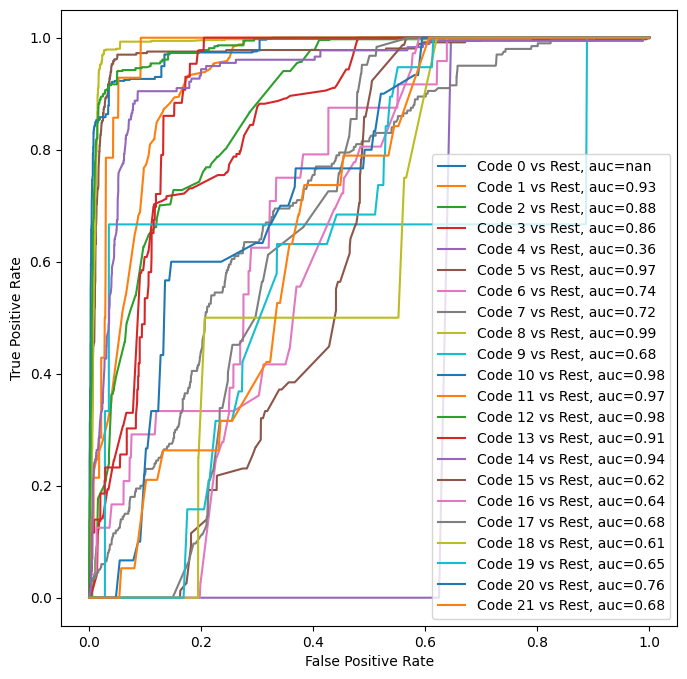

Sklearn Test Accuracy: 0.7407090255180682
Sklearn Test Precision: 0.6213013217576842
Sklearn Test Recall: 0.7407090255180682


C:\Users\KMult\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


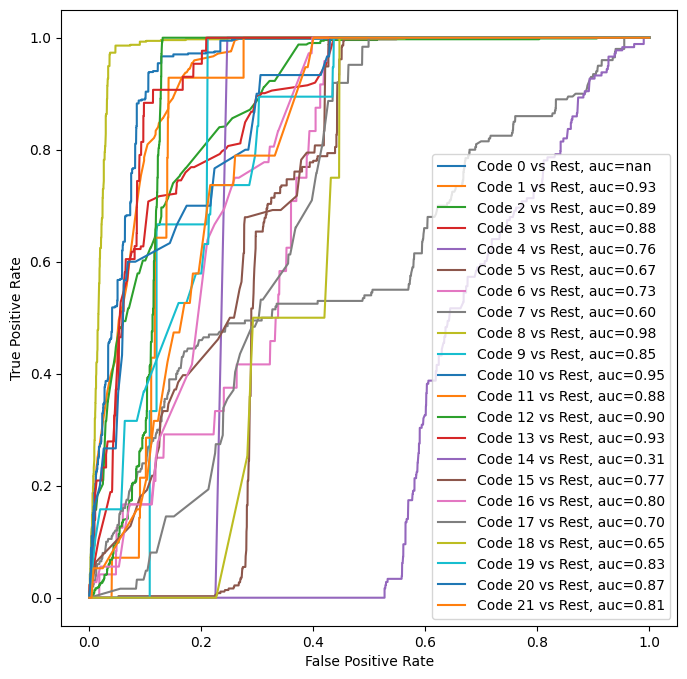

In [13]:
tar_file_path = "Diabetes-Data"
X_train, X_test, y_train, y_test = split_data(tar_file_path)

all_y = np.concatenate( (y_train, y_test) )
unique_y = np.unique(all_y)
output_size = len(unique_y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

layer_sizes = [X_train.shape[1], 4, output_size]
perceptron = Perceptron(layer_sizes)
losses, accuracies = perceptron.train(X_train, y_train, epochs=10, learning_rate=0.09, visualize=True)
predictions, probabilities = perceptron.predict(X_test)

for i in range(len(predictions)):
    predictions[i] = class_to_code[predictions[i]]
    y_test[i] = class_to_code[y_test[i]]

accuracy = metrics.accuracy_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions, average='weighted', zero_division=0)
recall = metrics.recall_score(y_test, predictions, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")

for i in range(len(y_test)):
    y_test[i] = code_to_class[y_test[i]]

y_test = np.eye(output_size)[y_test]
create_roc_curve(y_test, probabilities)

sk_perceptron = sk_mlp.MLPClassifier(hidden_layer_sizes=(4,), activation='relu', solver='adam', learning_rate_init=0.1, max_iter=1000)
sk_perceptron.fit(X_train, y_train)
y_pred = sk_perceptron.predict(X_test)
probabilities = sk_perceptron.predict_proba(X_test)


y_pred = np.eye(output_size)[y_pred]
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Sklearn Test Accuracy: {accuracy}")
print(f"Sklearn Test Precision: {precision}")
print(f"Sklearn Test Recall: {recall}")
create_roc_curve(y_test, probabilities)


- Uzycie wielu warstw ukrytych nie poprawia wyników, a nawet pogarsza je z powodu eksplozji gradientu, która w przypadku wielu wartsw ukrytych powoduje przycinanie gradientów dla wielu wag, co powoduje ostatecznie niedouczenie. Dlatego w tym przypadku używamy tylko jednej warstwy ukrytej.
- Wykorzystanie funkcji aktywacji `relu` w warstwie ukrytej i `softmax` w warstwie wyjściowej. Funkcja `relu` jest szybsza w obliczeniach niż funkcja `sigmoid` i `tanh`, a także zapobiega zanikającemu gradientowi. Funkcja `softmax` jest używana w warstwie wyjściowej, ponieważ jest to problem klasyfikacji wieloklasowej.
- Wykorzystanie batchy w celu przyspieszenia uczenia. Zamiast aktualizować wagi i biasy po każdej próbce, aktualizujemy je po każdym batchu. 

In [ ]:
def create_chart():
    tar_file_path = "Diabetes-Data"
    X_train, X_test, y_train, y_test = split_data(tar_file_path)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    layer_sizes = [X_train.shape[1], 4, output_size]
    fig, ax = plt.subplots(4, 3, figsize=(15, 15))
    fig2, ax2 = plt.subplots(4, 3, figsize=(15, 15))
    learning_rates = np.linspace(0.001, 1, 12)
    column = 0
    row = 0
    for index, learning_rate in enumerate(learning_rates):
        perceptron = Perceptron(layer_sizes, optimizer='adam')
        losses, accuracies = perceptron.train(X_train, y_train, epochs=30, learning_rate=learning_rate)

        predictions = perceptron.predict(X_test)
        test_accuracy = metrics.accuracy_score(y_test, predictions)

        ax[column][row].plot(losses,  linestyle='-', label=f"Learning rate: {learning_rate}")
        ax[column][row].set_xlabel("Epochs")
        ax[column][row].set_ylabel("Loss")
        ax[column][row].legend()

        ax2[column][row].scatter(learning_rate, test_accuracy, color='orange', label=f"Test accuracy: {test_accuracy}")
        ax2[column][row].plot(accuracies,  linestyle='-', label=f"Learning rate: {learning_rate}")
        ax2[column][row].set_xlabel("Epochs")
        ax2[column][row].set_ylabel("Accuracy")
        ax2[column][row].legend()
        if index % 3 == 2:
            column += 1
            row = 0
        else:
            row += 1

    fig3, ax3 = plt.subplots(4, 3, figsize=(15, 15))
    fig4, ax4 = plt.subplots(4, 3, figsize=(15, 15))
    learning_rates = np.linspace(0.001, 1, 12)
    column = 0
    row = 0
    for index, learning_rate in enumerate(learning_rates):
        perceptron = Perceptron(layer_sizes)
        losses, accuracies = perceptron.train(X_train, y_train, epochs=30, learning_rate=learning_rate)

        predictions = perceptron.predict(X_test)
        test_accuracy = metrics.accuracy_score(y_test, predictions)

        ax3[column][row].plot(losses, linestyle='-', label=f"Learning rate: {learning_rate}")
        ax3[column][row].set_xlabel("Epochs")
        ax3[column][row].set_ylabel("Loss")
        ax3[column][row].legend()

        ax4[column][row].scatter(learning_rate, test_accuracy, color='orange', label=f"Test accuracy: {test_accuracy}")
        ax4[column][row].plot(accuracies, linestyle='-', label=f"Laerning rate: {learning_rate}")
        ax4[column][row].set_xlabel("Epochs")
        ax4[column][row].set_ylabel("Accuracy")
        ax4[column][row].legend()
        if index % 3 == 2:
            column += 1
            row = 0
        else:
            row += 1

    plt.show()

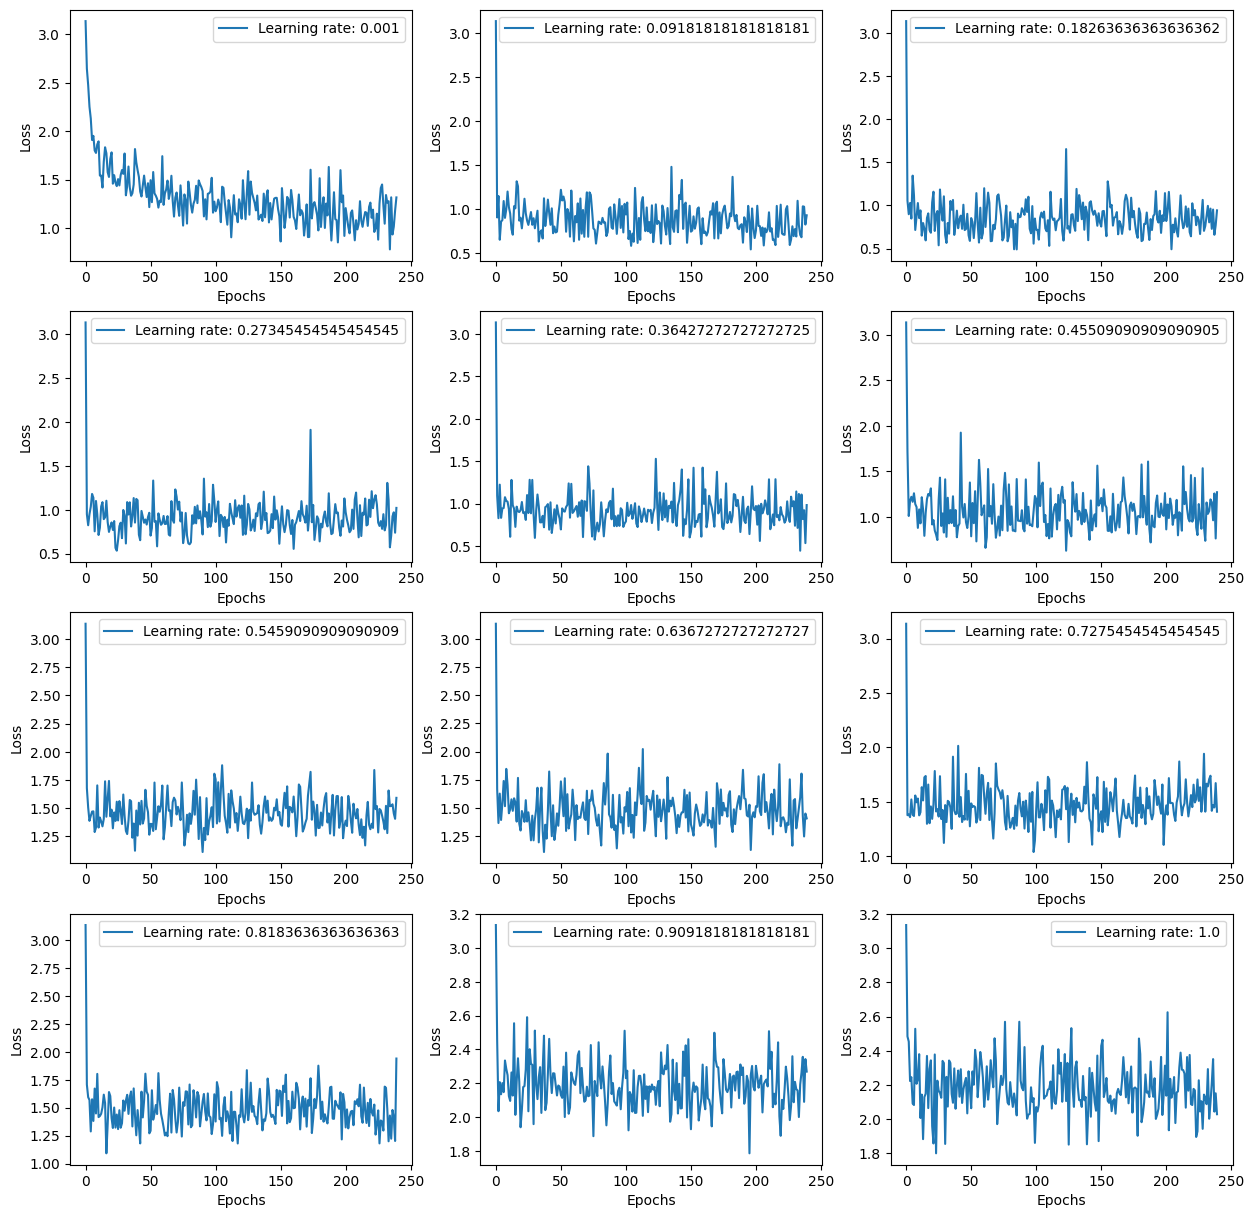

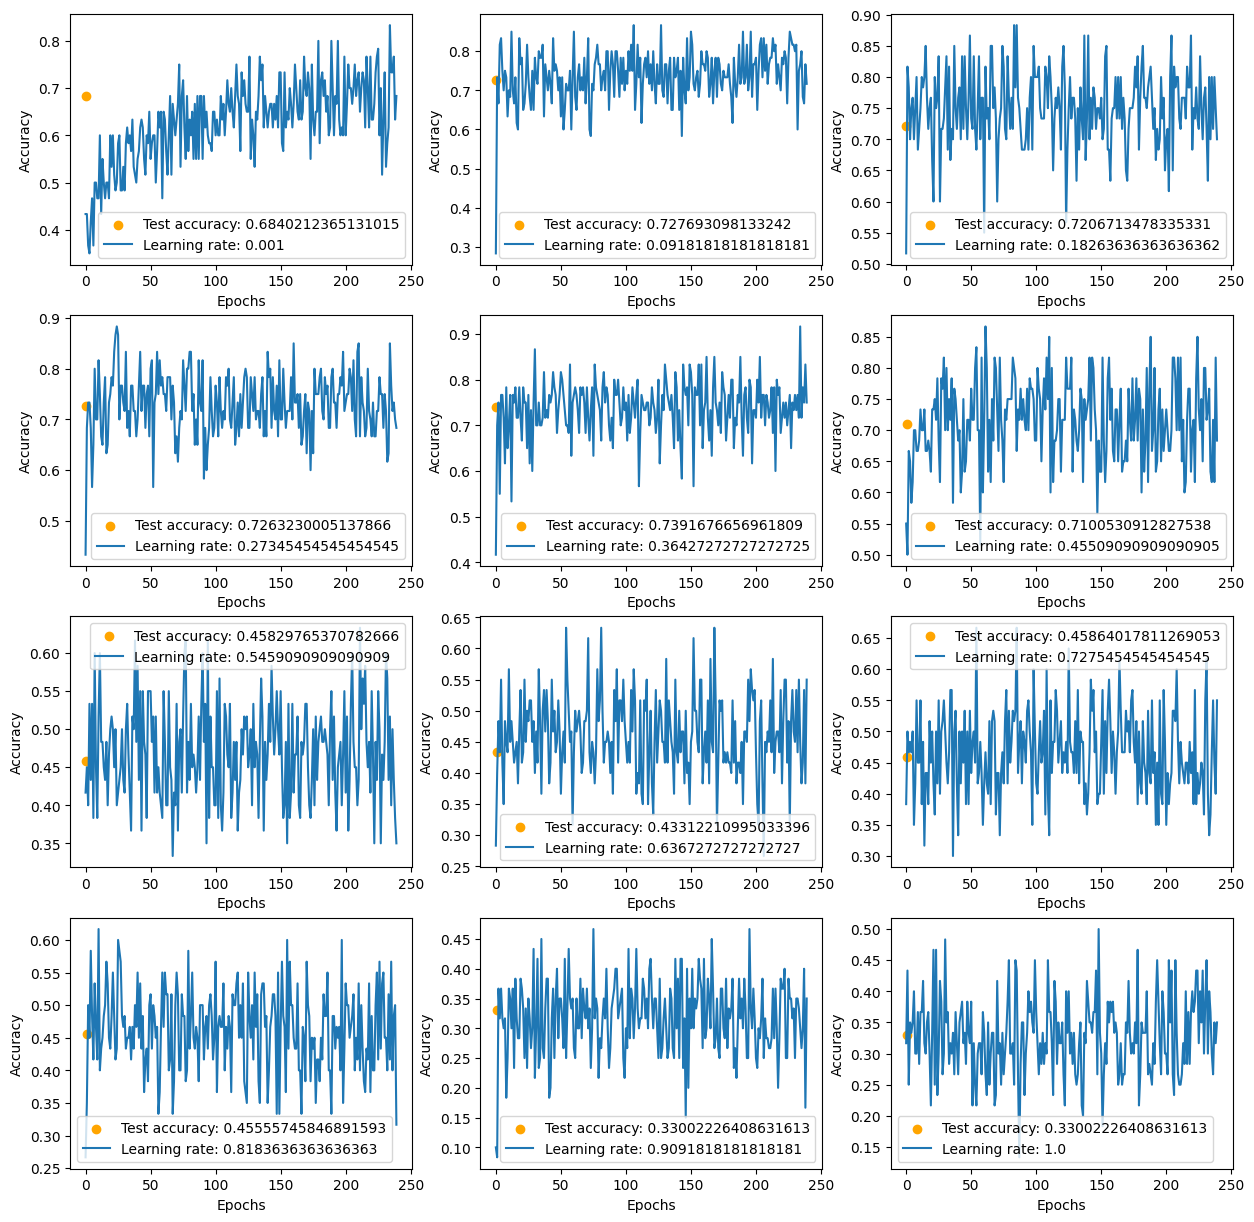

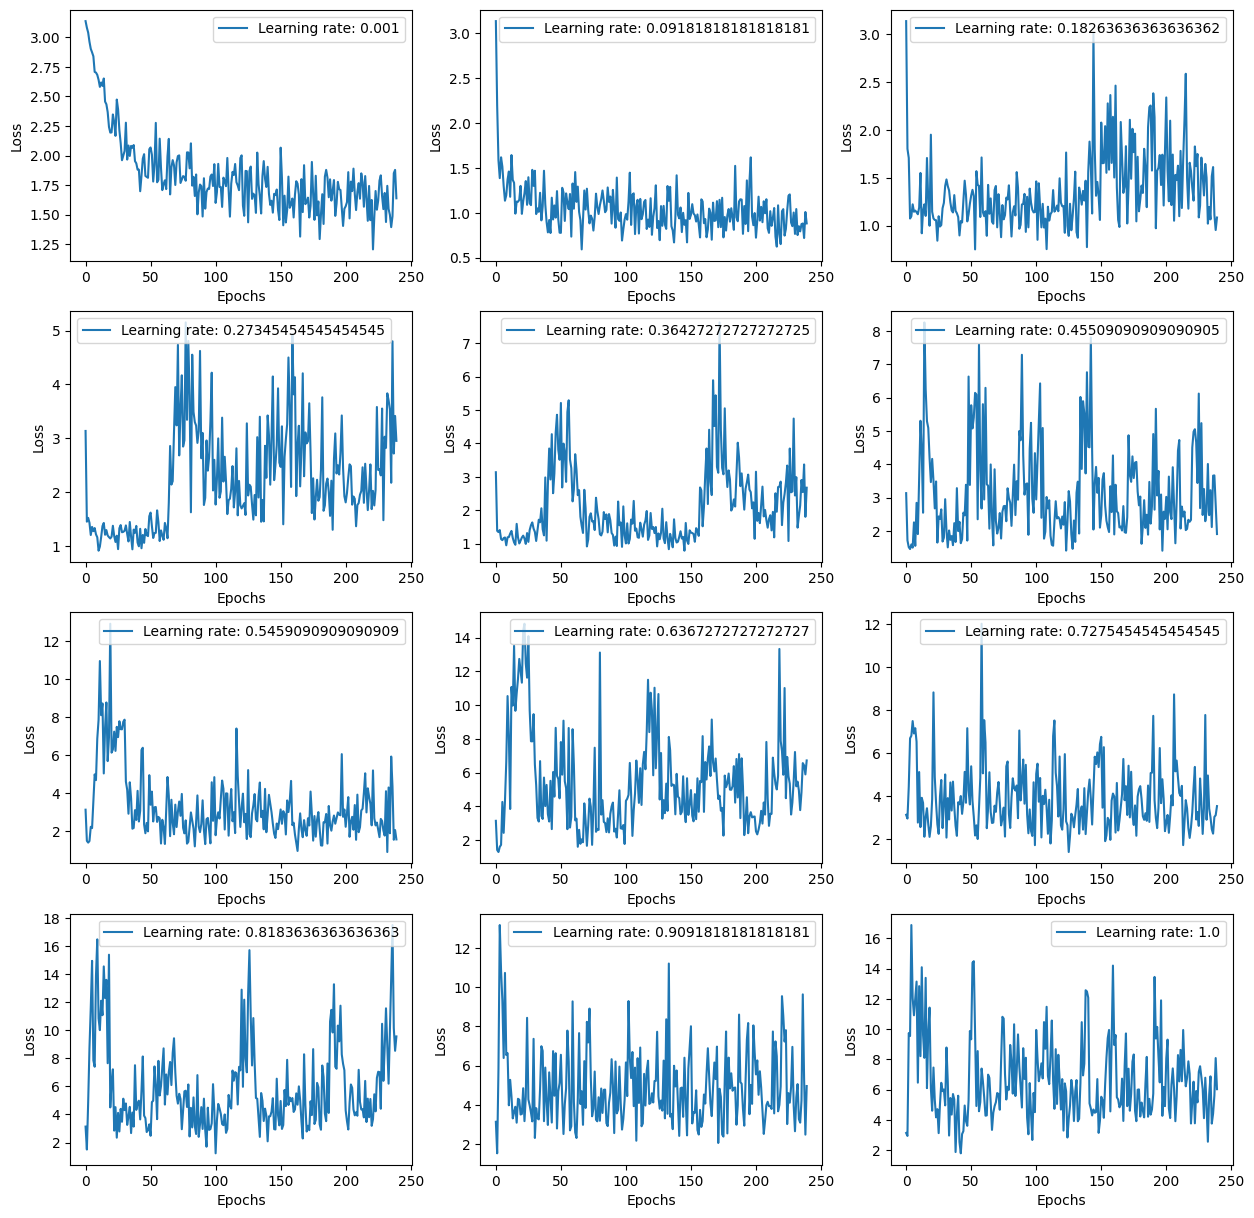

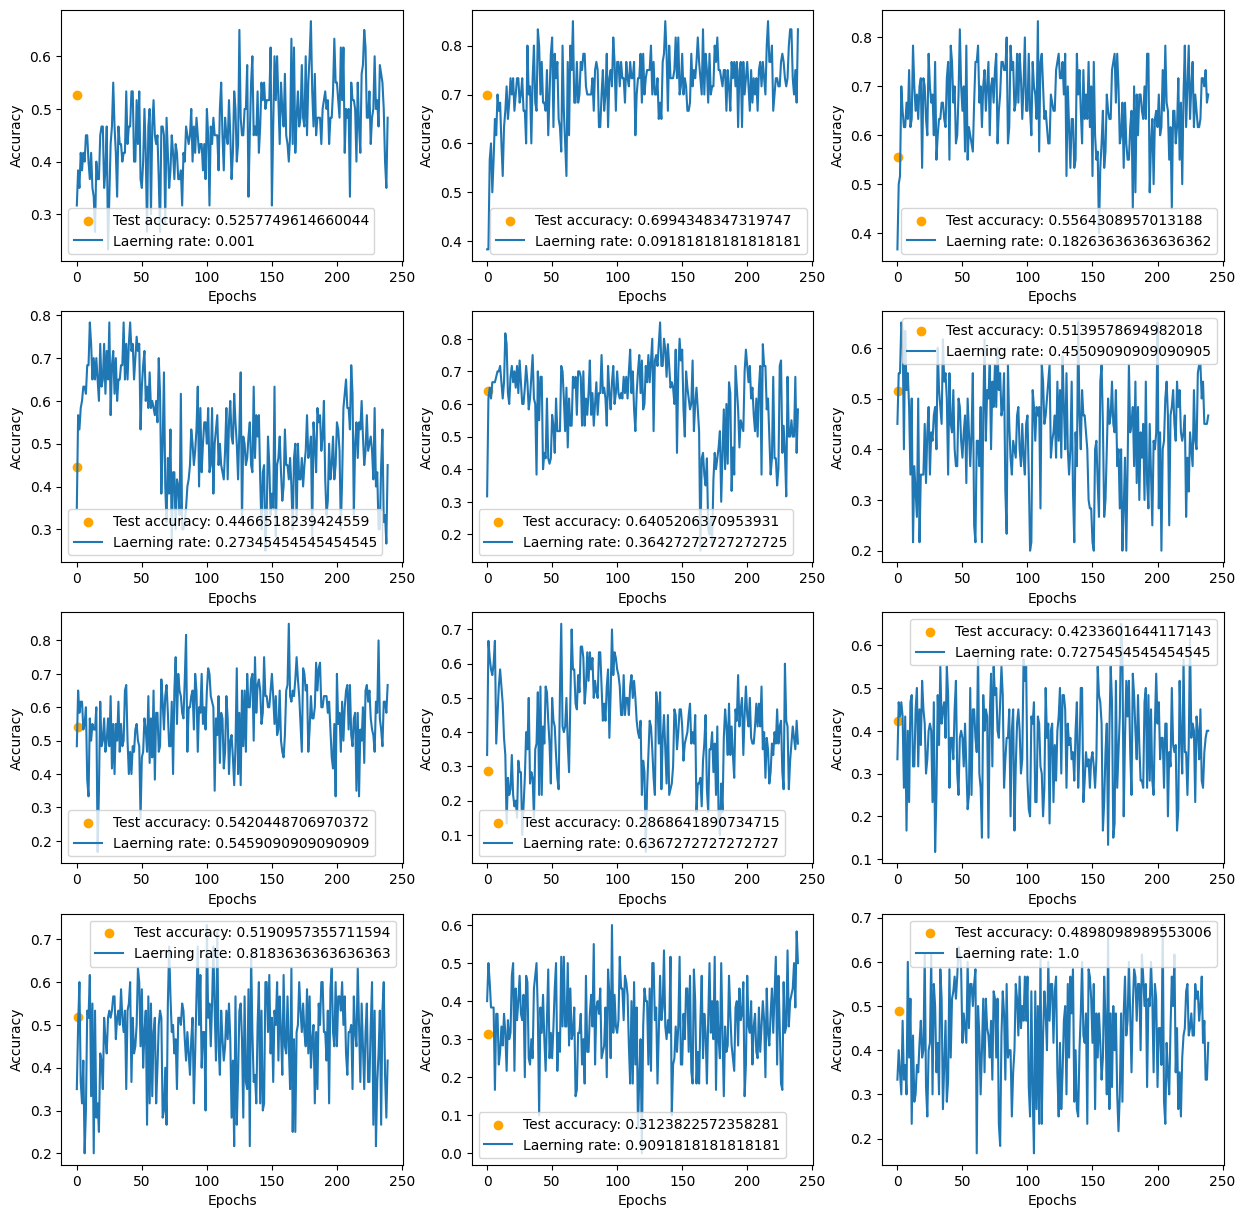

In [ ]:
create_chart()

Na podstawie wykresow, perceptron z optymalizatorem `adam` jest zawsze lepszy niż bez niego.
- Dla wartości learning_rate w okolicach 0.1 perceptron bez optymalizatora `adam` daje całkiem dobre wyniki
- Dla wartości learning_rate większej niż 0.2 perceptron bez optymalizatora `adam` zaczyna się zachowywać niestabilnie, a z optymalizatorem `adam` dalej daje całkiem dobre wyniki.
- Dla wartości learning_rate większej niż 0.5 perceptron daje słabe wyniki w obu przypadkach.

Dla za dużych wartości learnning_rate następuje zbyt chaotyczne zachowanie perceptronu, co powoduje, że nie jest w stanie nauczyć się poprawnie klasyfikować danych. I w przypadku dużego learning_rate często dokładność jest większa na zbiorze uczącym niż na testowym, co jest efektem przeuczenia

In [ ]:
def create_average_chart(optimizer='none'):
    tar_file_path = "Diabetes-Data"
    X_train, X_test, y_train, y_test = split_data(tar_file_path)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    layer_sizes = [X_train.shape[1], 4, output_size]
    learning_rates = np.linspace(0.001, 1, 12)
    column = 0
    row = 0
    accuracies = {}
    for index, learning_rate in enumerate(learning_rates):
        for i in range(100):
            perceptron = Perceptron(layer_sizes, optimizer=optimizer)
            perceptron.train(X_train, y_train, epochs=30, learning_rate=learning_rate)

            predictions = perceptron.predict(X_test)
            test_accuracy = metrics.accuracy_score(y_test, predictions)

            if learning_rate not in accuracies:
                accuracies[learning_rate] = test_accuracy
            else:
                accuracies[learning_rate] += test_accuracy

            if index % 3 == 2:
                column += 1
                row = 0
            else:
                row += 1

    for learning_rate in accuracies:
        accuracies[learning_rate] /= 100

    plt.plot(accuracies.keys(), accuracies.values())

    plt.show()

In [ ]:
create_average_chart(optimizer='adam')
create_average_chart(optimizer='none')